In [1]:
# import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

2024-02-11 23:40:49.386193: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-11 23:40:49.553373: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-11 23:40:49.553489: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-11 23:40:49.553788: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-11 23:40:49.630063: I tensorflow/core/platform/cpu_feature_g

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13220767030805869296
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5607784448
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14057515555197896663
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 4070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9"
xla_global_id: 416903419
]


2024-02-11 23:40:53.709515: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-11 23:40:53.751417: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-11 23:40:53.751479: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-11 23:40:55.988848: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-11 23:40:55.988985: I tensorflow/compile

In [ ]:
os.chdir("/mnt/")

In [6]:
rm -rf Data

In [ ]:
!git clone https://github.com/Annaantonin/Data.git

In [8]:
import Data as data

In [ ]:
!git clone https://github.com/Crunch-UQ4MI/neuraluq.git
#!git clone https://github.com/Annaantonin/Data.git
!pip install tensorflow-probability
!pip install scipy
import os
os.chdir("/tf/neuraluq/")
!python setup.py install

In [5]:
os.listdir(".")

['dataset',
 'README.md',
 'dist',
 'build',
 'output.mat',
 'examples',
 'NeuralUQ.egg-info',
 'output_ukF.mat',
 '.git',
 'setup.py',
 'Data',
 'neuraluq']

In [3]:
import neuraluq as neuq
import neuraluq.variables as neuq_vars
from neuraluq.config import tf

import numpy as np
import scipy.io as sio
from scipy.io import loadmat

import matplotlib.pyplot as plt


$loss_f:$

$\ddot{x_1}=[f_1-((k_1+k_2)x_1-k_2x_2)+((c_1+c_2)\dot{x_1}-c_2\dot{x_2}))]/m_1$<br>
$\ddot{x_2}=[f_2-((-k_2x_1+(k_2+k_3)x2-k_3x3)+(-c_2\dot{x_1}+(c_2+c_3)\dot{x_2}-c_3\dot{x_3}))]/m_2$ <br>
$\ddot{x_3}=[f_3-((-k_3x_2+k_3x_3)+(-c_3\dot{x_2}+c_3x_3)]/m_3$<br>

where $c_1=0.5, c_2=1; c_3=1.5$<br>
$f_1= f_2$=vectors of zeros<br>
$m1=m2=m3$=1;
<br>
$L_f=||target-\ddot{x_1}(t;\theta),\ddot{x_2}(t;\theta),\ddot{x_3}(t;\theta)||_2^2$<br>
$\theta=[k_1,k_2,k_3,x_1,x_2,x_3,f_3]$<br>

In [211]:
def pde_based_xtt(t, x1, x2, x3, f3, log_k2): # f3
    log_k2 = tf.clip_by_value(log_k2, clip_value_min=9, clip_value_max=14)
    x1_t = tf.gradients(x1, t)[0][..., 0:1]
    x2_t = tf.gradients(x2, t)[0][..., 0:1] 
    x3_t = tf.gradients(x3, t)[0][..., 0:1] 
    # f3=4*tf.sin(8*t)
    print('x1', x1.shape)
    x1_tt=-(((900+100*log_k2)*x1-100*log_k2*x2)+(1.5*x1_t-1*x2_t))
    x2_tt=-((-100*log_k2*x1+(100*log_k2+1300)*x2-1300*x3)+(-1*x1_t+2.5*x2_t-1.5*x3_t))
    x3_tt=f3-((-1300*x2+1300*x3)+(-1.5*x2_t+1.5*x3_t)) 
    
#     pde_1=-(((100*tf.exp(log_k1)+100*tf.exp(log_k2))*x1-100*tf.exp(log_k2)*x2)+(1.5*x1_t-1*x2_t))
#     pde_2=-((-100*tf.exp(log_k2)*x1+(100*tf.exp(log_k2)+100*tf.exp(log_k3))*x2-100*tf.exp(log_k3)*x3)+(-1*x1_t+2.5*x2_t-1.5*x3_t))
#     pde_3=f3-((-100*tf.exp(log_k3)*x2+100*tf.exp(log_k3)*x3)+(-1.5*x2_t+1.5*x3_t)) 
    
#     diff_1 = x1_tt - pde_1
#     diff_2 = x2_tt - pde_2
#     diff_3 = x3_tt - pde_3
    # print('x3_tt', x3_tt.shape)
    # out=tf.concat([x1_tt,x2_tt,x3_tt], axis=-1)
    # print('out', out.shape)
    return tf.concat([x1_tt,x2_tt,x3_tt], axis=-1)
    # return tf.concat([diff_1,diff_2,diff_3], axis=-1)

In [181]:
def pde_force(t, x1, x2, x3, f3): # f3
   
    x1_t = tf.gradients(x1, t)[0][..., 0:1]
    x2_t = tf.gradients(x2, t)[0][..., 0:1] 
    x3_t = tf.gradients(x3, t)[0][..., 0:1] 
    
    x1_tt = tf.gradients(x1_t, t)[0][..., 0:1]
    x2_tt = tf.gradients(x2_t, t)[0][..., 0:1] 
    x3_tt = tf.gradients(x3_t, t)[0][..., 0:1] 

    # print('x1', x1.shape)
    # x1_tt=-(((100*tf.exp(log_k1)+100*tf.exp(log_k2))*x1-100*tf.exp(log_k2)*x2)+(1.5*x1_t-1*x2_t))
    # x2_tt=-((-100*tf.exp(log_k2)*x1+(100*tf.exp(log_k2)+100*tf.exp(log_k3))*x2-100*tf.exp(log_k3)*x3)+(-1*x1_t+2.5*x2_t-1.5*x3_t))
    # x3_tt=f3-((-100*tf.exp(log_k3)*x2+100*tf.exp(log_k3)*x3)+(-1.5*x2_t+1.5*x3_t)) 
    
    pde_1 = x1_tt + (100*tf.exp(log_k1)+100*tf.exp(log_k2))*x1-100*tf.exp(log_k2)*x2+(1.5*x1_t-1*x2_t)
    

    pde_2= x2_tt + (-100*tf.exp(log_k2)*x1+(100*tf.exp(log_k2)+100*tf.exp(log_k3))*x2-100*tf.exp(log_k3)*x3)+(-1*x1_t+2.5*x2_t-1.5*x3_t)
    pde_3=x3_t + (-100*tf.exp(log_k3)*x2+100*tf.exp(log_k3)*x3)+(-1.5*x2_t+1.5*x3_t)
    
    diff_1 = 0 - pde_1
    diff_2 = 0 - pde_2
    diff_3 = f3 - pde_3
    # print('x3_tt', x3_tt.shape)
    # out=tf.concat([x1_tt,x2_tt,x3_tt], axis=-1)
    # print('out', out.shape)
    # return tf.concat([x1_tt,x2_tt,x3_tt], axis=-1)
    return tf.concat([diff_1,diff_2,diff_3], axis=-1)

$loss_u:$
$L_u=||target-x_1(t),x_2(t),x_3(t)||_2^2$

In [5]:
def pde_x(t,x1,x2,x3):
    return tf.concat([x1,x2,x3], axis=-1)

In [6]:
# def pde_xtt(t,  x1,x2,x3, *args):
    # return (-100*tf.exp(log_k3)*x2+100*tf.exp(log_k3)*x3

In [174]:
def pde_xt(t,  x1,x2,x3, *args):
    x1_t = tf.gradients(x1, t)[0][..., 0:1]   
    x2_t = tf.gradients(x2, t)[0][..., 0:1]
    x3_t = tf.gradients(x3, t)[0][..., 0:1]
    return tf.concat([x1_t,x2_t,x3_t], axis=-1)

$loss_{init}:$
$L_{init}=||x_1(t=0),x_2(t=0),x_3(t=0)||_2^2$<br>


In [7]:
def pde_init(t,  x1, x2, x3): 
    x1_t = tf.gradients(x1, t)[0]
    x2_t = tf.gradients(x2, t)[0]  
    x3_t = tf.gradients(x3, t)[0]
    # out=tf.concat([x1[0],x2[0],x3[0],  x1_t[0], x2_t[0], x3_t[0]], axis=-1)
    # print('out', out.shape)
    return tf.concat([x1[0],x2[0],x3[0],  x1_t[0], x2_t[0], x3_t[0]], axis=-1)

$loss_{grad}:$
$L_{grad}=||target-\ddot{x_1}(t),\ddot{x_2}(t),\ddot{x_3}(t)||_2^2$<br>

In [8]:
def pde_xtt(t,  x1,x2,x3, *args):
    x1_t = tf.gradients(x1, t)[0][..., 0:1]   
    x2_t = tf.gradients(x2, t)[0][..., 0:1]
    x3_t = tf.gradients(x3, t)[0][..., 0:1]
   
    x1_tt = tf.gradients(x1_t, t)[0][..., 0:1] 
    x2_tt = tf.gradients(x2_t, t)[0][..., 0:1] 
    x3_tt = tf.gradients(x3_t, t)[0][..., 0:1] 
    return tf.concat([x1_tt,x2_tt,x3_tt], axis=-1)

$Loss=\sum(loss_f+loss_u+loss_{init}+loss_{grad})$

Available data: 
1. Initial conditions for displacements $x_1[0]=x_2[0]=x_3[0]=0$
2. Accelerations $\ddot{x_1},\ddot{x_2},\ddot{x_3}$
3. Displacements $x_1,x_2,x_3$
4. We also know the forces at 1-2 DoF are equal to zero as I mentioned above.

In [9]:
def load_data(noise):

    data = sio.loadmat("Data/3_Dof_NoisySin_2000.mat")
    # data = sio.loadmat(r"C:\Users\Antonina\My Drive\CU_work\PINN project\3_Dof_NoisySin_2000.mat")
    #  t_x_train, t_f_train = data["t"], data["ymeas"]
    # data = matdata['data']
    t_train, x_tt_train =data["t"],data["a"]
    x1_tt_train, x2_tt_train, x3_tt_train= data["a1"],data["a2"], data["a3"]
    f3_train =  data['f3']
    x1,x2,x3=data["u1"],data["u2"],data["u3"]
    n=1000
    return  x1_tt_train[0:n], x2_tt_train[0:n], x3_tt_train[0:n], t_train[0:n], f3_train[0:n], x1[0:n],x2[0:n],x3[0:n]

In [225]:
# -*- coding: utf-8 -*-
"""
Created on Wed Oct  4 16:14:30 2023

@author: Antonina
"""
#%% 3DoF
# True values of stiffnesses:  k1=9, k2=11, k3=13
# Mass assumed to be identity so omitted for simplicity here


@neuq.utils.timer
def Trainable(x1_tt_train, x2_tt_train, x3_tt_train, t_train, f3_train, x1_train,x2_train,x3_train, noise, layers,   ):
  
    # build processes  

    process_x1 = neuq.process.Process(
        surrogate=neuq.surrogates.FNN(layers=layers),
        posterior=neuq_vars.fnn.Trainable(layers=layers ),# predicted displacement
    )

    process_x2 = neuq.process.Process(
        surrogate=neuq.surrogates.FNN(layers=layers),
        posterior=neuq_vars.fnn.Trainable(layers=layers),# predicted displacement
    )
    
    process_x3 = neuq.process.Process(
        surrogate=neuq.surrogates.FNN(layers=layers),
        posterior=neuq_vars.fnn.Trainable(layers=layers),# predicted displacement
    )
    process_f3 = neuq.process.Process(
        surrogate=neuq.surrogates.FNN(layers=layers),
        posterior=neuq_vars.fnn.Trainable(layers=layers),# force
    )


    
    # process_log_k1 = neuq.process.Process(
    #     surrogate=neuq.surrogates.Identity(),
    #     posterior=neuq_vars.const.Trainable(value=8),
    # )
    process_log_k2 = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        posterior=neuq_vars.const.Trainable(value=12),
    )
    # process_log_k3 = neuq.process.Process(
    #     surrogate=neuq.surrogates.Identity(),
    #     posterior=neuq_vars.const.Trainable(value=2.6),
    # )

    method = neuq.inferences.DEns(
        num_samples=20, num_iterations=80000, optimizer=tf.train.AdamOptimizer(1e-2),
    )

    # build losses

    loss_f3=neuq.likelihoods.MSE(
        inputs=t_train,
        targets=f3_train,
        processes=[process_f3], # tf train
        # pde=pde_f3,
        multiplier=1,
    )
    
    loss_f=neuq.likelihoods.MSE(
        inputs=t_train,
        targets=np.concatenate([np.zeros_like(t_train) for _ in range(3)], axis=-1),
        processes=[process_x1, process_x2, process_x3, process_f3], # tf train
        pde=pde_force,
        multiplier=1,
    )   
    
    loss_f_2=neuq.likelihoods.MSE(
        inputs=t_train,
        targets=np.concatenate([x1_tt_train, x2_tt_train, x3_tt_train], axis=-1),
        processes=[process_x1, process_x2, process_x3, process_f3, process_log_k2], # tf train
        pde=pde_based_xtt,
        multiplier=1e-5,
    )
    # loss_u = neuq.likelihoods.MSE(
    #     inputs=t_train,
    #     targets=np.concatenate([x1_train, x2_train, x3_train], axis=-1),
    #     processes=[process_x1, process_x2, process_x3],
    #     pde=pde_x, # X
    #     multiplier=0,
    # )  
    loss_init = neuq.likelihoods.MSE(
        inputs=t_train[0:1],
        targets=[0,0,0,0,0,0], 
        processes=[process_x1, process_x2, process_x3], # tf train
        pde=pde_init,
        multiplier=1,
    )   
    loss_grad = neuq.likelihoods.MSE(
        inputs=t_train, 
        targets=np.concatenate([x1_tt_train, x2_tt_train, x3_tt_train], axis=-1), 
        processes=[process_x1, process_x2, process_x3],
        pde=pde_xtt, 
        multiplier=1,
    )
    

    processes=[process_x1, process_x2, process_x3,  process_f3, process_log_k2]
    # build model
    model = neuq.models.Model(
        processes=processes,
        likelihoods=[
            # loss_u, 
                     # loss_f, 
            # loss_f3,
            loss_f_2,
                     loss_init, 
                     loss_grad
                    ],  #, loss_f1, loss_f2, loss2_init, loss3_init
    )
    # assign and compile method
    model.compile(method)
    # obtain posterior samples
    samples = model.run()

    processes=processes
    return processes, samples, model


if __name__ == "__main__":
    
    noise = 0

    x1_tt_train, x2_tt_train, x3_tt_train, t_train, f3_train, x1_train, x2_train, x3_train = load_data(noise)

    # t_x_tt_train, x_tt_train = train_x_tt
    # t_f_train, f_train = train_f

    layers = [1, 20, 20, 1]
    # layers_force = [1, 20, 20, 1]
    processes, samples, model = Trainable(x1_tt_train, x2_tt_train, x3_tt_train, t_train, f3_train, x1_train, x2_train, x3_train, noise, layers,  )

    x1_pred, x2_pred, x3_pred, f3_pred, log_k2 = model.predict(t_train, samples, processes, pde_fn=None)

2024-02-12 06:13:37.122558: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-12 06:13:37.122629: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-12 06:13:37.122640: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-12 06:13:37.122986: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-12 06:13:37.123014: I tensorflow/core/co

Supporting backend tensorflow.compat.v1

Compiling a Ensemble method

x1 (1000, 1)
Generating 0th sample by deep ensemble...


2024-02-12 06:13:40.332760: W tensorflow/c/c_api.cc:305] Operation '{name:'Variable_808/Assign' id:76058 op device:{requested: '', assigned: ''} def:{{{node Variable_808/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](Variable_808, Const_3200)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Iteration:  0 , loss:  11.925041
Iteration:  1000 , loss:  1.1953714
Iteration:  2000 , loss:  0.8856358
Iteration:  3000 , loss:  0.38831916
Iteration:  4000 , loss:  0.37018654
Iteration:  5000 , loss:  0.16765502
Iteration:  6000 , loss:  0.16538174
Iteration:  7000 , loss:  0.16375913
Iteration:  8000 , loss:  0.062866844
Iteration:  9000 , loss:  0.012565811
Iteration:  10000 , loss:  0.01212073
Iteration:  11000 , loss:  0.018716414
Iteration:  12000 , loss:  0.010078487
Iteration:  13000 , loss:  0.017473646
Iteration:  14000 , loss:  0.008541089
Iteration:  15000 , loss:  0.012224493
Iteration:  16000 , loss:  0.008026203
Iteration:  17000 , loss:  0.009868767
Iteration:  18000 , loss:  0.008191709
Iteration:  19000 , loss:  0.007928144
Iteration:  20000 , loss:  0.00776375
Iteration:  21000 , loss:  0.0077990503
Iteration:  22000 , loss:  0.007823141
Iteration:  23000 , loss:  0.00857931
Iteration:  24000 , loss:  0.025628898
Iteration:  25000 , loss:  0.005502228
Iteration:  

2024-02-12 06:21:55.047931: W tensorflow/c/c_api.cc:305] Operation '{name:'beta2_power_23/Assign' id:78071 op device:{requested: '', assigned: ''} def:{{{node beta2_power_23/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](beta2_power_23, beta2_power_23/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Iteration:  0 , loss:  8.599741
Iteration:  1000 , loss:  0.888795
Iteration:  2000 , loss:  0.8768361
Iteration:  3000 , loss:  0.5834891
Iteration:  4000 , loss:  0.5824516
Iteration:  5000 , loss:  0.5819305
Iteration:  6000 , loss:  0.5817747
Iteration:  7000 , loss:  0.58175874
Iteration:  8000 , loss:  0.5816466
Iteration:  9000 , loss:  0.58183694
Iteration:  10000 , loss:  0.5822005
Iteration:  11000 , loss:  0.58157104
Iteration:  12000 , loss:  0.58163655
Iteration:  13000 , loss:  0.5815693
Iteration:  14000 , loss:  0.5815543
Iteration:  15000 , loss:  0.5814431
Iteration:  16000 , loss:  0.58129174
Iteration:  17000 , loss:  0.5809067
Iteration:  18000 , loss:  0.58052206
Iteration:  19000 , loss:  0.58219296
Iteration:  20000 , loss:  0.58070844
Iteration:  21000 , loss:  0.58049333
Iteration:  22000 , loss:  0.5804467
Iteration:  23000 , loss:  0.5804027
Iteration:  24000 , loss:  0.5803639
Iteration:  25000 , loss:  0.5803151
Iteration:  26000 , loss:  0.58024114
Iterat

2024-02-12 06:29:47.494520: W tensorflow/c/c_api.cc:305] Operation '{name:'beta2_power_23/Assign' id:78071 op device:{requested: '', assigned: ''} def:{{{node beta2_power_23/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](beta2_power_23, beta2_power_23/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Iteration:  0 , loss:  9.5036125
Iteration:  1000 , loss:  1.1980913
Iteration:  2000 , loss:  0.9007849
Iteration:  3000 , loss:  0.595402
Iteration:  4000 , loss:  0.5845649
Iteration:  5000 , loss:  0.3751966
Iteration:  6000 , loss:  0.20295656
Iteration:  7000 , loss:  0.16383938
Iteration:  8000 , loss:  0.17816584
Iteration:  9000 , loss:  0.1624747
Iteration:  10000 , loss:  0.1656696
Iteration:  11000 , loss:  0.16174605
Iteration:  12000 , loss:  0.08880426
Iteration:  13000 , loss:  0.01615774
Iteration:  14000 , loss:  0.013491696
Iteration:  15000 , loss:  0.010567456
Iteration:  16000 , loss:  0.009502631
Iteration:  17000 , loss:  0.011481824
Iteration:  18000 , loss:  0.011270785
Iteration:  19000 , loss:  0.014564284
Iteration:  20000 , loss:  0.010006232
Iteration:  21000 , loss:  0.008216449
Iteration:  22000 , loss:  0.007839188
Iteration:  23000 , loss:  0.0073857107
Iteration:  24000 , loss:  0.0076666605
Iteration:  25000 , loss:  0.0071188756
Iteration:  26000 ,

2024-02-12 06:37:37.383683: W tensorflow/c/c_api.cc:305] Operation '{name:'beta2_power_23/Assign' id:78071 op device:{requested: '', assigned: ''} def:{{{node beta2_power_23/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](beta2_power_23, beta2_power_23/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Iteration:  0 , loss:  1.5489092
Iteration:  1000 , loss:  1.198222
Iteration:  2000 , loss:  1.1980413
Iteration:  3000 , loss:  1.1988157
Iteration:  4000 , loss:  1.1966608
Iteration:  5000 , loss:  0.58542246
Iteration:  6000 , loss:  0.3811522
Iteration:  7000 , loss:  0.38037062
Iteration:  8000 , loss:  0.17456716
Iteration:  9000 , loss:  0.17018741
Iteration:  10000 , loss:  0.16537997
Iteration:  11000 , loss:  0.17116725
Iteration:  12000 , loss:  0.16397835
Iteration:  13000 , loss:  0.16409788
Iteration:  14000 , loss:  0.16777842
Iteration:  15000 , loss:  0.16227978
Iteration:  16000 , loss:  0.16273038
Iteration:  17000 , loss:  0.16228148
Iteration:  18000 , loss:  0.16221619
Iteration:  19000 , loss:  0.1622264
Iteration:  20000 , loss:  0.16280997
Iteration:  21000 , loss:  0.162185
Iteration:  22000 , loss:  0.16247045
Iteration:  23000 , loss:  0.16219614
Iteration:  24000 , loss:  0.16217518
Iteration:  25000 , loss:  0.16264373
Iteration:  26000 , loss:  0.162443

2024-02-12 06:45:24.534644: W tensorflow/c/c_api.cc:305] Operation '{name:'beta2_power_23/Assign' id:78071 op device:{requested: '', assigned: ''} def:{{{node beta2_power_23/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](beta2_power_23, beta2_power_23/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Iteration:  0 , loss:  7.3674555
Iteration:  1000 , loss:  0.89320856
Iteration:  2000 , loss:  0.88827056
Iteration:  3000 , loss:  0.5848622
Iteration:  4000 , loss:  0.58575267
Iteration:  5000 , loss:  0.58238906
Iteration:  6000 , loss:  0.2123729
Iteration:  7000 , loss:  0.16289417
Iteration:  8000 , loss:  0.16240866
Iteration:  9000 , loss:  0.16230606
Iteration:  10000 , loss:  0.16226853
Iteration:  11000 , loss:  0.09030013
Iteration:  12000 , loss:  0.08983862
Iteration:  13000 , loss:  0.089570574
Iteration:  14000 , loss:  0.08916953
Iteration:  15000 , loss:  0.08816598
Iteration:  16000 , loss:  0.08596401
Iteration:  17000 , loss:  0.084524184
Iteration:  18000 , loss:  0.014928254
Iteration:  19000 , loss:  0.012837425
Iteration:  20000 , loss:  0.012634187
Iteration:  21000 , loss:  0.012920932
Iteration:  22000 , loss:  0.0115539115
Iteration:  23000 , loss:  0.011246507
Iteration:  24000 , loss:  0.009730728
Iteration:  25000 , loss:  0.0072940155
Iteration:  2600

2024-02-12 06:53:19.630782: W tensorflow/c/c_api.cc:305] Operation '{name:'beta2_power_23/Assign' id:78071 op device:{requested: '', assigned: ''} def:{{{node beta2_power_23/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](beta2_power_23, beta2_power_23/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Iteration:  0 , loss:  3.1014156
Iteration:  1000 , loss:  0.9140177
Iteration:  2000 , loss:  0.68132055
Iteration:  3000 , loss:  0.5854662
Iteration:  4000 , loss:  0.3832465
Iteration:  5000 , loss:  0.30333224
Iteration:  6000 , loss:  0.09705469
Iteration:  7000 , loss:  0.093968906
Iteration:  8000 , loss:  0.061509028
Iteration:  9000 , loss:  0.015523029
Iteration:  10000 , loss:  0.017907351
Iteration:  11000 , loss:  0.014300469
Iteration:  12000 , loss:  0.013626659
Iteration:  13000 , loss:  0.012910608
Iteration:  14000 , loss:  0.01351858
Iteration:  15000 , loss:  0.015077397
Iteration:  16000 , loss:  0.0083364
Iteration:  17000 , loss:  0.008535962
Iteration:  18000 , loss:  0.010284963
Iteration:  19000 , loss:  0.007823881
Iteration:  20000 , loss:  0.0077260355
Iteration:  21000 , loss:  0.012513297
Iteration:  22000 , loss:  0.007681981
Iteration:  23000 , loss:  0.007527664
Iteration:  24000 , loss:  0.008520849
Iteration:  25000 , loss:  0.009998761
Iteration:  

2024-02-12 07:01:24.322833: W tensorflow/c/c_api.cc:305] Operation '{name:'beta2_power_23/Assign' id:78071 op device:{requested: '', assigned: ''} def:{{{node beta2_power_23/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](beta2_power_23, beta2_power_23/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Iteration:  0 , loss:  13.785874
Iteration:  1000 , loss:  1.1979464
Iteration:  2000 , loss:  0.88967866
Iteration:  3000 , loss:  0.66799873
Iteration:  4000 , loss:  0.37833238
Iteration:  5000 , loss:  0.24437577
Iteration:  6000 , loss:  0.16820489
Iteration:  7000 , loss:  0.16415286
Iteration:  8000 , loss:  0.16350512
Iteration:  9000 , loss:  0.16331615
Iteration:  10000 , loss:  0.15486866
Iteration:  11000 , loss:  0.012000565
Iteration:  12000 , loss:  0.011491916
Iteration:  13000 , loss:  0.010895585
Iteration:  14000 , loss:  0.008663135
Iteration:  15000 , loss:  0.008268564
Iteration:  16000 , loss:  0.009540278
Iteration:  17000 , loss:  0.008065133
Iteration:  18000 , loss:  0.008296109
Iteration:  19000 , loss:  0.0077469735
Iteration:  20000 , loss:  0.011062197
Iteration:  21000 , loss:  0.0066263457
Iteration:  22000 , loss:  0.006270763
Iteration:  23000 , loss:  0.006054354
Iteration:  24000 , loss:  0.005788653
Iteration:  25000 , loss:  0.0065508313
Iteration

2024-02-12 07:09:24.289028: W tensorflow/c/c_api.cc:305] Operation '{name:'beta2_power_23/Assign' id:78071 op device:{requested: '', assigned: ''} def:{{{node beta2_power_23/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](beta2_power_23, beta2_power_23/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Iteration:  0 , loss:  6.3986435
Iteration:  1000 , loss:  1.1981034
Iteration:  2000 , loss:  1.19772
Iteration:  3000 , loss:  0.8885961
Iteration:  4000 , loss:  0.58613765
Iteration:  5000 , loss:  0.58770806
Iteration:  6000 , loss:  0.5443868
Iteration:  7000 , loss:  0.5164867
Iteration:  8000 , loss:  0.50513166
Iteration:  9000 , loss:  0.22193204
Iteration:  10000 , loss:  0.01260156
Iteration:  11000 , loss:  0.011309345
Iteration:  12000 , loss:  0.029027497
Iteration:  13000 , loss:  0.010783011
Iteration:  14000 , loss:  0.01727341
Iteration:  15000 , loss:  0.010364933
Iteration:  16000 , loss:  0.010248968
Iteration:  17000 , loss:  0.011416092
Iteration:  18000 , loss:  0.008241348
Iteration:  19000 , loss:  0.0076991282
Iteration:  20000 , loss:  0.007338106
Iteration:  21000 , loss:  0.006850706
Iteration:  22000 , loss:  0.0060108625
Iteration:  23000 , loss:  0.007181534
Iteration:  24000 , loss:  0.0058285133
Iteration:  25000 , loss:  0.0057353307
Iteration:  260

2024-02-12 07:17:24.771893: W tensorflow/c/c_api.cc:305] Operation '{name:'beta2_power_23/Assign' id:78071 op device:{requested: '', assigned: ''} def:{{{node beta2_power_23/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](beta2_power_23, beta2_power_23/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Iteration:  0 , loss:  8.054618
Iteration:  1000 , loss:  1.1978619
Iteration:  2000 , loss:  0.89123386
Iteration:  3000 , loss:  0.675281
Iteration:  4000 , loss:  0.37916115
Iteration:  5000 , loss:  0.3706347
Iteration:  6000 , loss:  0.16621265
Iteration:  7000 , loss:  0.16323817
Iteration:  8000 , loss:  0.16277333
Iteration:  9000 , loss:  0.16258617
Iteration:  10000 , loss:  0.16248624
Iteration:  11000 , loss:  0.16239284
Iteration:  12000 , loss:  0.16239229
Iteration:  13000 , loss:  0.16252263
Iteration:  14000 , loss:  0.08937349
Iteration:  15000 , loss:  0.08641628
Iteration:  16000 , loss:  0.12924856
Iteration:  17000 , loss:  0.015990406
Iteration:  18000 , loss:  0.017609524
Iteration:  19000 , loss:  0.010442739
Iteration:  20000 , loss:  0.010476296
Iteration:  21000 , loss:  0.010243843
Iteration:  22000 , loss:  0.01027266
Iteration:  23000 , loss:  0.01610043
Iteration:  24000 , loss:  0.01011674
Iteration:  25000 , loss:  0.010434023
Iteration:  26000 , loss:

2024-02-12 07:25:31.720177: W tensorflow/c/c_api.cc:305] Operation '{name:'beta2_power_23/Assign' id:78071 op device:{requested: '', assigned: ''} def:{{{node beta2_power_23/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](beta2_power_23, beta2_power_23/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Iteration:  0 , loss:  3.043578
Iteration:  1000 , loss:  1.1981027
Iteration:  2000 , loss:  0.8946795
Iteration:  3000 , loss:  0.6102652
Iteration:  4000 , loss:  0.37834734
Iteration:  5000 , loss:  0.3697253
Iteration:  6000 , loss:  0.23729916
Iteration:  7000 , loss:  0.16630907
Iteration:  8000 , loss:  0.09373214
Iteration:  9000 , loss:  0.09275681
Iteration:  10000 , loss:  0.09269828
Iteration:  11000 , loss:  0.014435482
Iteration:  12000 , loss:  0.012663015
Iteration:  13000 , loss:  0.01070213
Iteration:  14000 , loss:  0.008338885
Iteration:  15000 , loss:  0.007871359
Iteration:  16000 , loss:  0.0076867035
Iteration:  17000 , loss:  0.00768458
Iteration:  18000 , loss:  0.0076617263
Iteration:  19000 , loss:  0.005952358
Iteration:  20000 , loss:  0.006289117
Iteration:  21000 , loss:  0.005703047
Iteration:  22000 , loss:  0.00626974
Iteration:  23000 , loss:  0.011252478
Iteration:  24000 , loss:  0.005480219
Iteration:  25000 , loss:  0.011634314
Iteration:  26000

2024-02-12 07:33:30.606762: W tensorflow/c/c_api.cc:305] Operation '{name:'beta2_power_23/Assign' id:78071 op device:{requested: '', assigned: ''} def:{{{node beta2_power_23/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](beta2_power_23, beta2_power_23/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Iteration:  0 , loss:  6.4639826
Iteration:  1000 , loss:  1.1978452
Iteration:  2000 , loss:  0.8869934
Iteration:  3000 , loss:  0.6768275
Iteration:  4000 , loss:  0.37467209
Iteration:  5000 , loss:  0.16787128
Iteration:  6000 , loss:  0.17036714
Iteration:  7000 , loss:  0.16476986
Iteration:  8000 , loss:  0.09262921
Iteration:  9000 , loss:  0.015979411
Iteration:  10000 , loss:  0.024627168
Iteration:  11000 , loss:  0.013444996
Iteration:  12000 , loss:  0.012931713
Iteration:  13000 , loss:  0.012679663
Iteration:  14000 , loss:  0.012349992
Iteration:  15000 , loss:  0.01271095
Iteration:  16000 , loss:  0.011694318
Iteration:  17000 , loss:  0.011496241
Iteration:  18000 , loss:  0.011266102
Iteration:  19000 , loss:  0.01240889
Iteration:  20000 , loss:  0.010217371
Iteration:  21000 , loss:  0.008623448
Iteration:  22000 , loss:  0.008749394
Iteration:  23000 , loss:  0.008615869
Iteration:  24000 , loss:  0.007986963
Iteration:  25000 , loss:  0.008539271
Iteration:  26

2024-02-12 07:41:28.530249: W tensorflow/c/c_api.cc:305] Operation '{name:'beta2_power_23/Assign' id:78071 op device:{requested: '', assigned: ''} def:{{{node beta2_power_23/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](beta2_power_23, beta2_power_23/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Iteration:  0 , loss:  19.743752
Iteration:  1000 , loss:  1.1981599
Iteration:  2000 , loss:  1.197514
Iteration:  3000 , loss:  0.8849145
Iteration:  4000 , loss:  0.79647726
Iteration:  5000 , loss:  0.5112347
Iteration:  6000 , loss:  0.5102625
Iteration:  7000 , loss:  0.5075793
Iteration:  8000 , loss:  0.43410295
Iteration:  9000 , loss:  0.4324202
Iteration:  10000 , loss:  0.43267947
Iteration:  11000 , loss:  0.43557835
Iteration:  12000 , loss:  0.43204358
Iteration:  13000 , loss:  0.47027436
Iteration:  14000 , loss:  0.43240374
Iteration:  15000 , loss:  0.43180278
Iteration:  16000 , loss:  0.43418428
Iteration:  17000 , loss:  0.43248567
Iteration:  18000 , loss:  0.43139923
Iteration:  19000 , loss:  0.4308412
Iteration:  20000 , loss:  0.42844534
Iteration:  21000 , loss:  0.42851853
Iteration:  22000 , loss:  0.43197843
Iteration:  23000 , loss:  0.4282168
Iteration:  24000 , loss:  0.43029922
Iteration:  25000 , loss:  0.42817903
Iteration:  26000 , loss:  0.4284366

2024-02-12 07:49:21.580941: W tensorflow/c/c_api.cc:305] Operation '{name:'beta2_power_23/Assign' id:78071 op device:{requested: '', assigned: ''} def:{{{node beta2_power_23/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](beta2_power_23, beta2_power_23/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Iteration:  0 , loss:  8.596486
Iteration:  1000 , loss:  1.1982144
Iteration:  2000 , loss:  1.1978381
Iteration:  3000 , loss:  0.8830682
Iteration:  4000 , loss:  0.37977314
Iteration:  5000 , loss:  0.3628489
Iteration:  6000 , loss:  0.17100094
Iteration:  7000 , loss:  0.1636265
Iteration:  8000 , loss:  0.08985618
Iteration:  9000 , loss:  0.012849996
Iteration:  10000 , loss:  0.012486887
Iteration:  11000 , loss:  0.015669873
Iteration:  12000 , loss:  0.012243556
Iteration:  13000 , loss:  0.011864147
Iteration:  14000 , loss:  0.015694048
Iteration:  15000 , loss:  0.014289172
Iteration:  16000 , loss:  0.009365512
Iteration:  17000 , loss:  0.0108638555
Iteration:  18000 , loss:  0.009136779
Iteration:  19000 , loss:  0.038231853
Iteration:  20000 , loss:  0.008913662
Iteration:  21000 , loss:  0.008774167
Iteration:  22000 , loss:  0.015252849
Iteration:  23000 , loss:  0.008568861
Iteration:  24000 , loss:  0.00844008
Iteration:  25000 , loss:  0.008768143
Iteration:  260

2024-02-12 07:57:18.039050: W tensorflow/c/c_api.cc:305] Operation '{name:'beta2_power_23/Assign' id:78071 op device:{requested: '', assigned: ''} def:{{{node beta2_power_23/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](beta2_power_23, beta2_power_23/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Iteration:  0 , loss:  3.9752002
Iteration:  1000 , loss:  1.1981806
Iteration:  2000 , loss:  1.1980797
Iteration:  3000 , loss:  0.894259
Iteration:  4000 , loss:  0.8899859
Iteration:  5000 , loss:  0.6045555
Iteration:  6000 , loss:  0.58613265
Iteration:  7000 , loss:  0.5848109
Iteration:  8000 , loss:  0.5834296
Iteration:  9000 , loss:  0.17480473
Iteration:  10000 , loss:  0.16694929
Iteration:  11000 , loss:  0.16515611
Iteration:  12000 , loss:  0.16475694
Iteration:  13000 , loss:  0.16441134
Iteration:  14000 , loss:  0.16347069
Iteration:  15000 , loss:  0.16259666
Iteration:  16000 , loss:  0.16246954
Iteration:  17000 , loss:  0.16244715
Iteration:  18000 , loss:  0.16224416
Iteration:  19000 , loss:  0.17709832
Iteration:  20000 , loss:  0.16241008
Iteration:  21000 , loss:  0.16379395
Iteration:  22000 , loss:  0.16317637
Iteration:  23000 , loss:  0.16569246
Iteration:  24000 , loss:  0.16684057
Iteration:  25000 , loss:  0.16216148
Iteration:  26000 , loss:  0.16212

2024-02-12 08:05:09.945635: W tensorflow/c/c_api.cc:305] Operation '{name:'beta2_power_23/Assign' id:78071 op device:{requested: '', assigned: ''} def:{{{node beta2_power_23/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](beta2_power_23, beta2_power_23/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Iteration:  0 , loss:  14.269359
Iteration:  1000 , loss:  1.1981505
Iteration:  2000 , loss:  1.1979747
Iteration:  3000 , loss:  0.66899556
Iteration:  4000 , loss:  0.38215792
Iteration:  5000 , loss:  0.36905068
Iteration:  6000 , loss:  0.09354587
Iteration:  7000 , loss:  0.090529524
Iteration:  8000 , loss:  0.014295306
Iteration:  9000 , loss:  0.012646797
Iteration:  10000 , loss:  0.012274612
Iteration:  11000 , loss:  0.0119320145
Iteration:  12000 , loss:  0.011568038
Iteration:  13000 , loss:  0.011261346
Iteration:  14000 , loss:  0.029228233
Iteration:  15000 , loss:  0.009385061
Iteration:  16000 , loss:  0.011093604
Iteration:  17000 , loss:  0.008199612
Iteration:  18000 , loss:  0.007828272
Iteration:  19000 , loss:  0.034119077
Iteration:  20000 , loss:  0.006362228
Iteration:  21000 , loss:  0.0061880946
Iteration:  22000 , loss:  0.0058990708
Iteration:  23000 , loss:  0.0057428633
Iteration:  24000 , loss:  0.00563266
Iteration:  25000 , loss:  0.0055359323
Itera

2024-02-12 08:13:12.649399: W tensorflow/c/c_api.cc:305] Operation '{name:'beta2_power_23/Assign' id:78071 op device:{requested: '', assigned: ''} def:{{{node beta2_power_23/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](beta2_power_23, beta2_power_23/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Iteration:  0 , loss:  1.9274259
Iteration:  1000 , loss:  1.1981969
Iteration:  2000 , loss:  1.1977068
Iteration:  3000 , loss:  1.0014924
Iteration:  4000 , loss:  0.99573416
Iteration:  5000 , loss:  1.0550625
Iteration:  6000 , loss:  0.98761564
Iteration:  7000 , loss:  0.78704786
Iteration:  8000 , loss:  0.78231466
Iteration:  9000 , loss:  0.78248215
Iteration:  10000 , loss:  0.7820114
Iteration:  11000 , loss:  0.7821765
Iteration:  12000 , loss:  0.7818203
Iteration:  13000 , loss:  0.49266234
Iteration:  14000 , loss:  0.16465145
Iteration:  15000 , loss:  0.16236483
Iteration:  16000 , loss:  0.16228834
Iteration:  17000 , loss:  0.098163
Iteration:  18000 , loss:  0.014100233
Iteration:  19000 , loss:  0.012245748
Iteration:  20000 , loss:  0.011693913
Iteration:  21000 , loss:  0.010615266
Iteration:  22000 , loss:  0.012111127
Iteration:  23000 , loss:  0.008272713
Iteration:  24000 , loss:  0.007578843
Iteration:  25000 , loss:  0.007706643
Iteration:  26000 , loss:  

2024-02-12 08:21:07.022336: W tensorflow/c/c_api.cc:305] Operation '{name:'beta2_power_23/Assign' id:78071 op device:{requested: '', assigned: ''} def:{{{node beta2_power_23/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](beta2_power_23, beta2_power_23/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Iteration:  0 , loss:  5.872092
Iteration:  1000 , loss:  1.0193813
Iteration:  2000 , loss:  0.79281825
Iteration:  3000 , loss:  0.7838346
Iteration:  4000 , loss:  0.21493338
Iteration:  5000 , loss:  0.094762124
Iteration:  6000 , loss:  0.091802314
Iteration:  7000 , loss:  0.09057042
Iteration:  8000 , loss:  0.08993171
Iteration:  9000 , loss:  0.08949198
Iteration:  10000 , loss:  0.012852179
Iteration:  11000 , loss:  0.01219577
Iteration:  12000 , loss:  0.012153648
Iteration:  13000 , loss:  0.011992937
Iteration:  14000 , loss:  0.011786993
Iteration:  15000 , loss:  0.011044612
Iteration:  16000 , loss:  0.009983243
Iteration:  17000 , loss:  0.009615567
Iteration:  18000 , loss:  0.012822721
Iteration:  19000 , loss:  0.009564763
Iteration:  20000 , loss:  0.010333743
Iteration:  21000 , loss:  0.018721322
Iteration:  22000 , loss:  0.00831418
Iteration:  23000 , loss:  0.008224742
Iteration:  24000 , loss:  0.007104276
Iteration:  25000 , loss:  0.0084156655
Iteration:  

2024-02-12 08:29:07.450643: W tensorflow/c/c_api.cc:305] Operation '{name:'beta2_power_23/Assign' id:78071 op device:{requested: '', assigned: ''} def:{{{node beta2_power_23/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](beta2_power_23, beta2_power_23/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Iteration:  0 , loss:  4.271537
Iteration:  1000 , loss:  1.1980617
Iteration:  2000 , loss:  0.90073955
Iteration:  3000 , loss:  0.8728079
Iteration:  4000 , loss:  0.5837204
Iteration:  5000 , loss:  0.58280945
Iteration:  6000 , loss:  0.38030317
Iteration:  7000 , loss:  0.35115227
Iteration:  8000 , loss:  0.16607766
Iteration:  9000 , loss:  0.16416833
Iteration:  10000 , loss:  0.16382761
Iteration:  11000 , loss:  0.16323939
Iteration:  12000 , loss:  0.16282445
Iteration:  13000 , loss:  0.16262417
Iteration:  14000 , loss:  0.16254655
Iteration:  15000 , loss:  0.16243227
Iteration:  16000 , loss:  0.16786404
Iteration:  17000 , loss:  0.16515201
Iteration:  18000 , loss:  0.16230212
Iteration:  19000 , loss:  0.162177
Iteration:  20000 , loss:  0.16258036
Iteration:  21000 , loss:  0.16211006
Iteration:  22000 , loss:  0.16212995
Iteration:  23000 , loss:  0.16199858
Iteration:  24000 , loss:  0.16198868
Iteration:  25000 , loss:  0.16191345
Iteration:  26000 , loss:  0.161

2024-02-12 08:37:06.057719: W tensorflow/c/c_api.cc:305] Operation '{name:'beta2_power_23/Assign' id:78071 op device:{requested: '', assigned: ''} def:{{{node beta2_power_23/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](beta2_power_23, beta2_power_23/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Iteration:  0 , loss:  7.4026
Iteration:  1000 , loss:  0.9094657
Iteration:  2000 , loss:  0.8881726
Iteration:  3000 , loss:  0.5860334
Iteration:  4000 , loss:  0.58327854
Iteration:  5000 , loss:  0.58190644
Iteration:  6000 , loss:  0.5816754
Iteration:  7000 , loss:  0.5815029
Iteration:  8000 , loss:  0.5813905
Iteration:  9000 , loss:  0.58130074
Iteration:  10000 , loss:  0.58125055
Iteration:  11000 , loss:  0.17483544
Iteration:  12000 , loss:  0.16893256
Iteration:  13000 , loss:  0.1672544
Iteration:  14000 , loss:  0.16599195
Iteration:  15000 , loss:  0.16490671
Iteration:  16000 , loss:  0.16438462
Iteration:  17000 , loss:  0.16422649
Iteration:  18000 , loss:  0.17072603
Iteration:  19000 , loss:  0.16279517
Iteration:  20000 , loss:  0.1666614
Iteration:  21000 , loss:  0.08473044
Iteration:  22000 , loss:  0.083450265
Iteration:  23000 , loss:  0.08217733
Iteration:  24000 , loss:  0.010900413
Iteration:  25000 , loss:  0.01067849
Iteration:  26000 , loss:  0.010508

2024-02-12 08:45:12.852278: W tensorflow/c/c_api.cc:305] Operation '{name:'beta2_power_23/Assign' id:78071 op device:{requested: '', assigned: ''} def:{{{node beta2_power_23/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](beta2_power_23, beta2_power_23/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Iteration:  0 , loss:  16.526352
Iteration:  1000 , loss:  1.1980945
Iteration:  2000 , loss:  1.1976163
Iteration:  3000 , loss:  0.63127023
Iteration:  4000 , loss:  0.5119111
Iteration:  5000 , loss:  0.5103745
Iteration:  6000 , loss:  0.30759367
Iteration:  7000 , loss:  0.12701868
Iteration:  8000 , loss:  0.09360105
Iteration:  9000 , loss:  0.020237695
Iteration:  10000 , loss:  0.01474258
Iteration:  11000 , loss:  0.012186912
Iteration:  12000 , loss:  0.01150906
Iteration:  13000 , loss:  0.011296783
Iteration:  14000 , loss:  0.014326315
Iteration:  15000 , loss:  0.011108599
Iteration:  16000 , loss:  0.012321013
Iteration:  17000 , loss:  0.011016814
Iteration:  18000 , loss:  0.01287351
Iteration:  19000 , loss:  0.010816597
Iteration:  20000 , loss:  0.011744651
Iteration:  21000 , loss:  0.010468166
Iteration:  22000 , loss:  0.010315529
Iteration:  23000 , loss:  0.009975054
Iteration:  24000 , loss:  0.009878249
Iteration:  25000 , loss:  0.014476203
Iteration:  2600

In [95]:
# targets=np.concatenate([x1_train, x2_train, x3_train], axis=-1)
# plt.plot(targets,'r')

[8.955226  8.983744  8.9935255 8.99227   8.771768  8.92856   8.993646
 8.925299  8.913981  8.95579   8.993603  8.96259   8.911862  8.985901
 8.968192  8.993472  8.985896  8.994607  8.821659  8.981066 ]


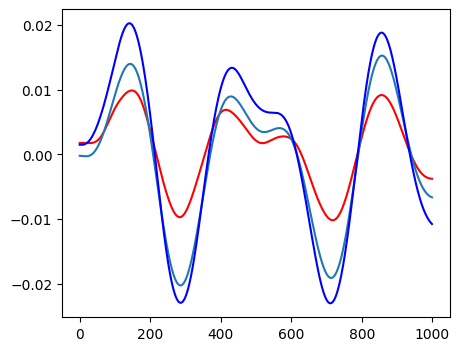

In [226]:
x1_pred, x2_pred, x3_pred, f3_pred, log_k1 = model.predict(t_train, samples, processes, pde_fn=None)

print(log_k1)

plt.plot(x1_pred[0,:,:],'r')
plt.plot(x2_pred[0,:,:])
plt.plot(x3_pred[0,:,:],'b')
# plt.plot(f3_pred[0,:,:])

x1 (20, 1000, 1)


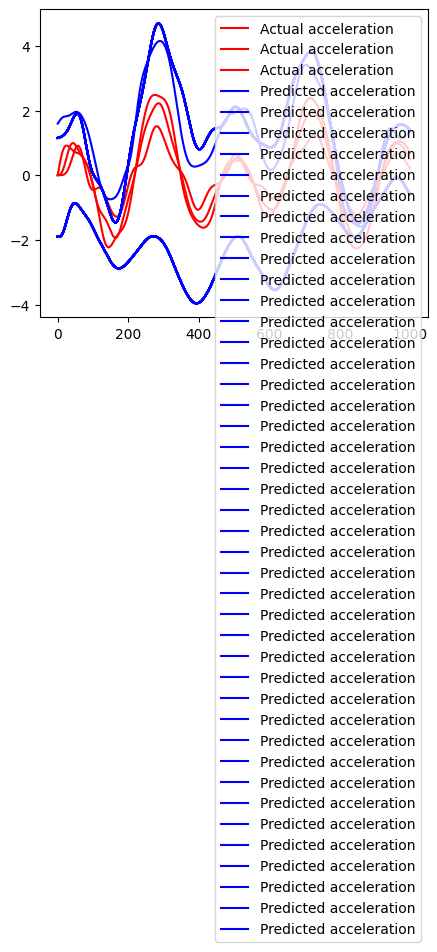

In [228]:
targets=np.concatenate([x1_tt_train, x2_tt_train, x3_tt_train], axis=-1)
plt.plot(targets,'r', label='Actual acceleration')
(x_tt_pred, ) = model.predict(t_train, samples, processes, pde_fn=pde_based_xtt)
plt.plot(x_tt_pred[9,:,:],'b',label='Predicted acceleration')
plt.legend()

In [ ]:
targets=np.concatenate([x1_tt_train, x2_tt_train, x3_tt_train], axis=-1)
plt.rcParams['figure.figsize'] = [15, 10]
plt.plot(t_train, targets,'r', label='Actual acceleration')
(x_tt_pred, ) = model.predict(t_train, samples, processes, pde_fn=pde_force)
plt.plot(t_train, x_tt_pred[0,:,:],'b',label='Predicted acceleration')
# plt.legend()
plt.legend(loc="lower left")

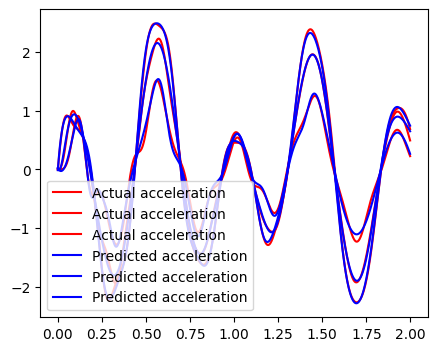

In [229]:
 targets=np.concatenate([x1_tt_train, x2_tt_train, x3_tt_train], axis=-1)
# plt.rcParams['figure.figsize'] = [15, 10]
plt.plot(t_train, targets,'r', label='Actual acceleration')
(x_tt_pred, ) = model.predict(t_train, samples, processes, pde_fn=pde_xtt)
plt.plot(t_train, x_tt_pred[0,:,:],'b',label='Predicted acceleration')
# plt.legend()
plt.legend(loc="lower left")

In [94]:
(x_t_pred, ) = model.predict(t_train, samples, processes, pde_fn=pde_xt)
x1_t=x_t_pred[:,:,0]
x2_t=x_t_pred[:,:,1]
x3_t=x_t_pred[:,:,2]
f3=f3_pred

x1=x1_pred
x2=x2_pred
x3=x3_pred

x1_tt=-(((100*9+100*11)*x1-100*11*x2)+(1.5*x1_t-1*x2_t))
x2_tt=-((-100*11*x1+(100*11+100*13)*x2-100*13*x3)+(-1*x1_t+2.5*x2_t-1.5*x3_t))
x3_tt=f3-((-100*13*x2+100*13*x3)+(-1.5*x2_t+1.5*x3_t)) 

print(x1.shape)
# plt.plot(x1_t.T)
# plt.plot(x1_train)

(1, 1000, 1)


In [230]:
print(log_k2)

[8.955226  8.983744  8.9935255 8.99227   8.771768  8.92856   8.993646
 8.925299  8.913981  8.95579   8.993603  8.96259   8.911862  8.985901
 8.968192  8.993472  8.985896  8.994607  8.821659  8.981066 ]


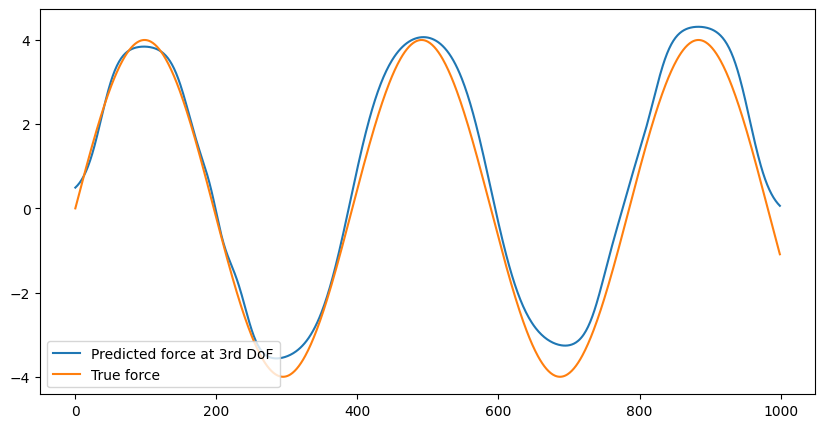

In [236]:
#Force prediction f_3
plt.rcParams['figure.figsize'] = [10, 5]
plt.plot(f3_pred[9,:,0], label='Predicted force at 3rd DoF')
plt.plot(f3_train, label='True force')
# plt.legend()
plt.legend(loc="lower left")

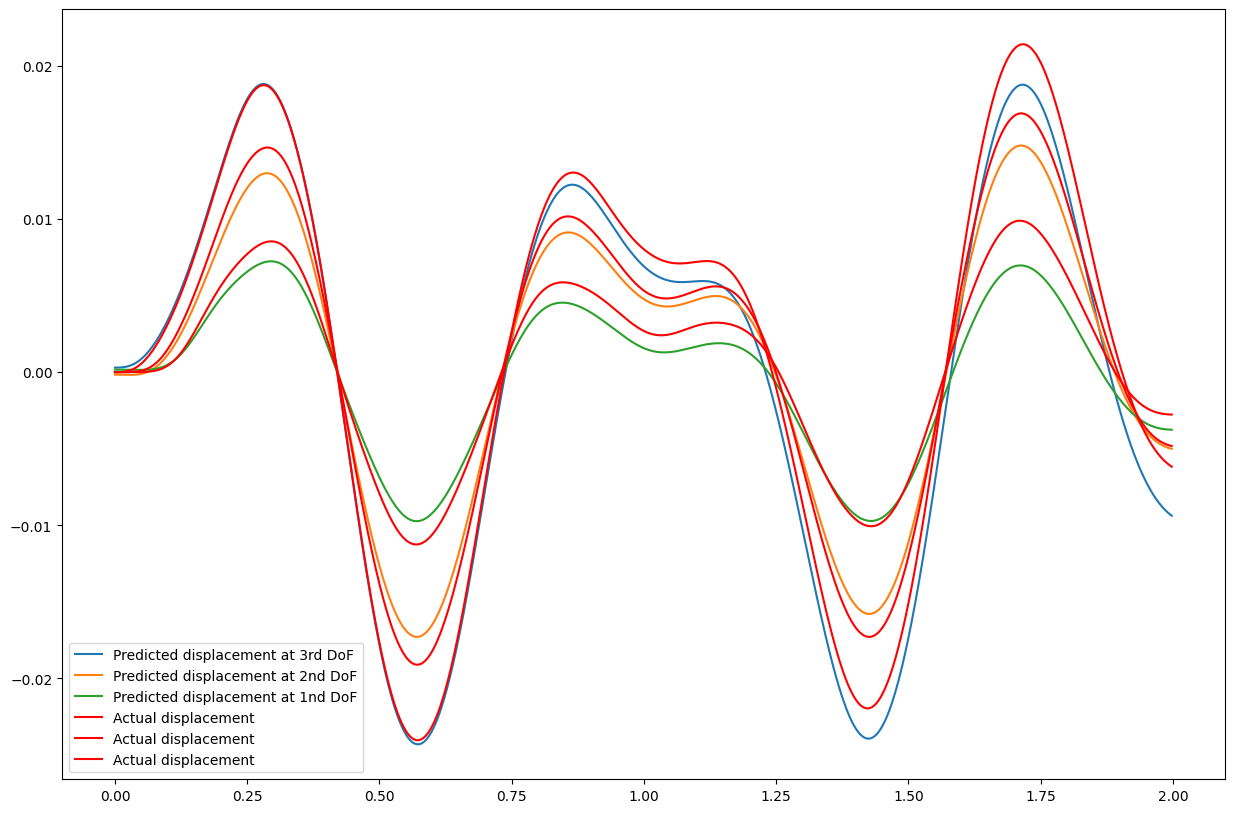

In [232]:
plt.rcParams['figure.figsize'] = [15, 10]
plt.plot(t_train,np.mean(x3_pred,axis=(0, 2)),label='Predicted displacement at 3rd DoF')
plt.plot(t_train,np.mean(x2_pred,axis=(0, 2)),label='Predicted displacement at 2nd DoF')
plt.plot(t_train,np.mean(x1_pred,axis=(0, 2)),label='Predicted displacement at 1nd DoF')
targets=np.concatenate([x1_train, x2_train, x3_train], axis=-1)
plt.plot(t_train,targets,'r',label='Actual displacement')
plt.legend(loc="lower left")
# plt.legend()

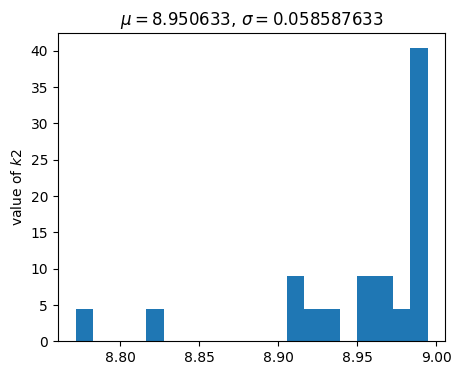

NameError: name 'logk3_pred' is not defined

In [234]:
plt.rcParams['figure.figsize'] = [5, 4]
# neuq.utils.hist(log_k1.flatten(), name="value of $k1$")
neuq.utils.hist(log_k2.flatten(), name="value of $k2$")
neuq.utils.hist(np.exp(logk3_pred).flatten(), name="value of $k3$")
